2024-12-24 09:56:33,663 - INFO - Initializing the Fully Quantum Classifier
2024-12-24 09:56:33,664 - INFO - Initializing Data Loaders
2024-12-24 09:56:33,664 - INFO - Loading dataset from directory: /Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals
2024-12-24 09:56:33,690 - INFO - Loaded 2880 samples.
2024-12-24 09:56:33,692 - INFO - Data Loaders initialized successfully: 2304 training samples, 576 testing samples
2024-12-24 09:56:33,708 - INFO - Model architecture:
FullyQuantumClassifier(
  (fc): Linear(in_features=10, out_features=10, bias=True)
)
2024-12-24 09:56:33,709 - INFO - Starting training process
2024-12-24 09:56:33,711 - INFO - Starting training for 20 epochs
2024-12-24 09:56:46,833 - INFO - Epoch 1/20 - Average Loss: 2.2789      
2024-12-24 09:56:56,979 - INFO - Epoch 2/20 - Average Loss: 2.2045      
2024-12-24 09:57:08,326 - INFO - Epoch 3/20 - Average Loss: 2.1393      
2024-12-24 09:57:18,206 - INFO - Epoch 4/20 - Average Loss: 2.0782      
2024-12-24 0

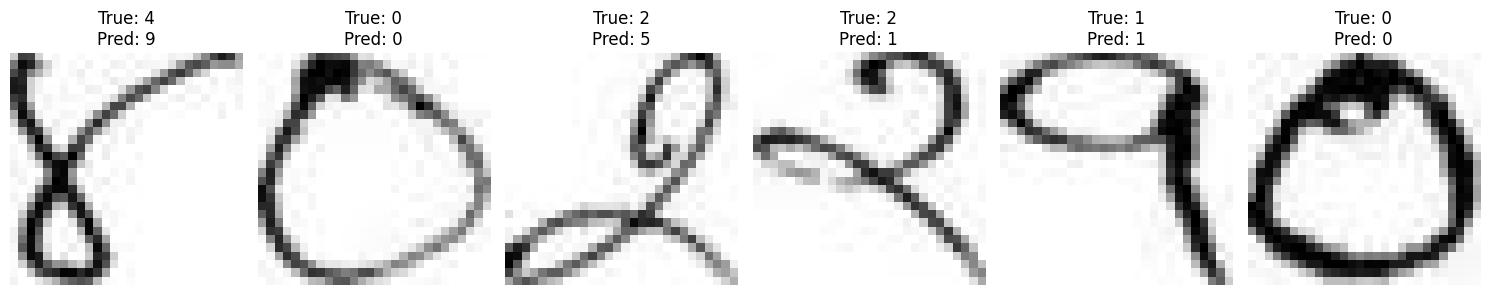

2024-12-24 10:00:41,740 - INFO - Visualization complete
2024-12-24 10:00:41,741 - INFO - Fully Quantum Classifier execution completed


In [1]:
# fully_quantum_classifier.py

"""
Problem Statement:
Classify Nepali numerals (0-9) using a Fully Quantum Classifier (FQC).

Dataset:
NepaliMNISTDataset, organized with images in subdirectories per class.
"""

import os
import logging
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm  # For progress bars
import pennylane as qml
from pennylane import numpy as pnp

# ==============================
# Logging Setup
# ==============================
def setup_logging(log_file='training.log'):
    """
    Sets up logging to output to both console and a file with a specific format.
    Args:
        log_file (str): Filename for the log file.
    """
    logger = logging.getLogger('FullyQuantumClassifier')
    logger.setLevel(logging.INFO)

    # Create handlers
    c_handler = logging.StreamHandler()
    f_handler = logging.FileHandler(log_file, mode='w')

    c_handler.setLevel(logging.INFO)
    f_handler.setLevel(logging.INFO)

    # Create formatter and add it to handlers
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    c_handler.setFormatter(formatter)
    f_handler.setFormatter(formatter)

    # Add handlers to the logger
    if not logger.handlers:
        logger.addHandler(c_handler)
        logger.addHandler(f_handler)

    return logger

logger = setup_logging()

# ==============================
# Dataset Definition
# ==============================
class NepaliMNISTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images organized in subdirectories per class.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        logger.info("Loading dataset from directory: %s", root_dir)
        for label in range(10):
            label_dir = os.path.join(root_dir, str(label))
            if not os.path.isdir(label_dir):
                logger.warning("Directory for label %d does not exist: %s", label, label_dir)
                continue
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                if os.path.isfile(img_path) and img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    self.data.append(img_path)
                    self.labels.append(label)
        logger.info("Loaded %d samples.", len(self.data))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = Image.open(self.data[idx]).convert('L')  # Convert to grayscale
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# ==============================
# Data Transformations
# ==============================
# Resize images to 28x28 pixels and normalize
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),  # 28x28 pixels = 784 features
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ==============================
# Data Loaders Initialization
# ==============================
ROOT_DIR = "/Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals"  # Update this path as needed

def initialize_data_loaders(root_dir, batch_size=16):
    """
    Initializes and returns the training and testing data loaders.
    Args:
        root_dir (str): Root directory of the dataset.
        batch_size (int): Number of samples per batch.
    Returns:
        Tuple[DataLoader, DataLoader]: Training and testing data loaders.
    """
    logger.info("Initializing Data Loaders")
    dataset = NepaliMNISTDataset(root_dir=root_dir, transform=transform)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    logger.info("Data Loaders initialized successfully: %d training samples, %d testing samples", train_size, test_size)
    return train_loader, test_loader

# ==============================
# Fully Quantum Classifier (FQC)
# ==============================
n_qubits = 10  # Number of qubits (2^10 = 1024 features)
dev = qml.device("default.qubit", wires=n_qubits)

def amplitude_encoding(inputs):
    """
    Encodes input data into quantum states using amplitude encoding.
    Args:
        inputs (Tensor): Batch of input data of shape (batch_size, 784).
    Returns:
        Tensor: Normalized and padded input data of shape (batch_size, 1024).
    """
    batch_size = inputs.shape[0]
    # Flatten images to (batch_size, 784)
    inputs_flat = inputs.view(batch_size, -1)
    # Pad with zeros to reach 1024 features
    padding = torch.zeros(batch_size, 1024 - 784, device=inputs.device, dtype=inputs.dtype)
    inputs_padded = torch.cat([inputs_flat, padding], dim=1)
    # Normalize each input vector to unit norm
    norm = torch.norm(inputs_padded, dim=1, keepdim=True)
    return inputs_padded / norm

def quantum_circuit(weights, inputs):
    """
    Defines a quantum circuit with amplitude encoding and variational layers.
    Args:
        weights (Tensor): Trainable weights for the circuit, shape (n_qubits, 3).
        inputs (Tensor): Input data encoded into the circuit, shape (n_qubits,).
    Returns:
        List[Expectation values]: Expectation values of PauliZ on all qubits.
    """
    # Amplitude Encoding
    qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=False)

    # Variational Layers: Rotations
    for i in range(n_qubits):
        qml.Rot(*weights[i], wires=i)
    
    # Entangling layer with CNOT gates
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i+1])
    
    # Measurement: Expectation value of PauliZ on all qubits
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

@qml.qnode(dev, interface='torch', diff_method='parameter-shift')
def qnode(weights, inputs):
    return quantum_circuit(weights, inputs)

class FullyQuantumClassifier(nn.Module):
    def __init__(self):
        super(FullyQuantumClassifier, self).__init__()
        # Initialize variational parameters: 3 angles for each qubit (for Rot gates)
        self.weights = nn.Parameter(0.01 * torch.randn(n_qubits, 3))
        # Classical layer to map quantum outputs to class probabilities
        self.fc = nn.Linear(n_qubits, 10)  # Mapping n_qubits features to 10 classes

    def forward(self, x, device):
        # Amplitude Encoding: Normalize and pad inputs
        x = amplitude_encoding(x)
        batch_size = x.shape[0]
        outputs = []

        # Loop over the batch to execute the quantum circuit for each sample
        for i in range(batch_size):
            sample = x[i]
            q_out = qnode(self.weights, sample)
            q_out = torch.tensor(q_out, dtype=torch.float32, device=device)  # Ensure float32
            outputs.append(q_out)

        # Stack all quantum outputs: shape (batch_size, n_qubits)
        qnode_outputs = torch.stack(outputs)
        # Pass through the classical linear layer
        out = self.fc(qnode_outputs)
        return out

# ==============================
# Training Function
# ==============================
def train_model(model, train_loader, optimizer, loss_fn, epochs, device):
    """
    Trains the model for a specified number of epochs.
    Args:
        model (nn.Module): The neural network model.
        train_loader (DataLoader): DataLoader for training data.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        loss_fn (nn.Module): Loss function.
        epochs (int): Number of training epochs.
        device (torch.device): Device to run the training on.
    """
    logger.info("Starting training for %d epochs", epochs)
    model.train()
    for epoch in range(1, epochs + 1):
        epoch_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch}/{epochs}', leave=False)
        for images, labels in progress_bar:
            # Move images and labels to device
            images = images.to(device)
            labels = labels.long().to(device)

            optimizer.zero_grad()
            outputs = model(images, device)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix({'Loss': loss.item()})
        avg_loss = epoch_loss / len(train_loader)
        logger.info(f"Epoch {epoch}/{epochs} - Average Loss: {avg_loss:.4f}")

# ==============================
# Evaluation Function
# ==============================
def evaluate_model(model, test_loader, device):
    """
    Evaluates the model on the test dataset and returns the accuracy.
    Args:
        model (nn.Module): The neural network model.
        test_loader (DataLoader): DataLoader for testing data.
        device (torch.device): Device to run the evaluation on.
    Returns:
        float: Accuracy percentage.
    """
    logger.info("Starting evaluation")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluating', leave=False):
            images = images.to(device)
            labels = labels.long().to(device)
            outputs = model(images, device)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    logger.info(f"Evaluation completed with Accuracy: {accuracy:.2f}%")
    return accuracy

# ==============================
# Visualization Function
# ==============================
def visualize_predictions(model, test_loader, device, num_images=6):
    """
    Visualizes a few predictions from the model.
    Args:
        model (nn.Module): The neural network model.
        test_loader (DataLoader): DataLoader for testing data.
        device (torch.device): Device to run the visualization on.
        num_images (int): Number of images to visualize.
    """
    logger.info("Visualizing predictions")
    model.eval()
    images, labels = next(iter(test_loader))
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images, device)
    _, predictions = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for idx, ax in enumerate(axes):
        if idx >= len(images):
            break
        # Reshape the image to 28x28
        image = images[idx].cpu().numpy().reshape(28, 28)
        ax.imshow(image, cmap='gray')
        ax.set_title(f"True: {labels[idx].item()}\nPred: {predictions[idx].item()}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    logger.info("Visualization complete")

# ==============================
# Main Execution
# ==============================
def main():
    logger.info("Initializing the Fully Quantum Classifier")
    train_loader, test_loader = initialize_data_loaders(ROOT_DIR)

    model = FullyQuantumClassifier()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)  # Higher learning rate for faster convergence
    loss_fn = nn.CrossEntropyLoss()

    logger.info("Model architecture:\n%s", model)
    logger.info("Starting training process")
    train_model(model, train_loader, optimizer, loss_fn, epochs=20, device=device)  # Adjust epochs as needed

    logger.info("Starting evaluation on test data")
    accuracy = evaluate_model(model, test_loader, device=device)
    logger.info(f"Test Accuracy: {accuracy:.2f}%")

    logger.info("Starting visualization of predictions")
    visualize_predictions(model, test_loader, device=device)

    logger.info("Fully Quantum Classifier execution completed")

if __name__ == "__main__":
    main()
